# Building a Regression MLP Using the Sequential API

Let’s switch to the California housing problem and tackle it using a regression neural network. California Housing Prices is a dataset based on data from the 1990 California census. This dataset includes features such as the population, median income, and median housing price for each district in California.

### Using Pandas to load the dataset
Let’s load the california housing dataset:

In [1]:
import pandas as pd

df_housing = pd.read_excel('/content/sample_data/housing_price_train.xlsx')

df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,83252.0,NEAR BAY,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,83014.0,NEAR BAY,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,72574.0,NEAR BAY,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,56431.0,NEAR BAY,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,38462.0,NEAR BAY,342200.0


Let’s take a look at the shape and data type of the data:

In [2]:
print('Training data shape:', df_housing.shape)
print('Training data type :', df_housing.dtypes)

Training data shape: (15323, 10)
Training data type : longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
median_house_value    float64
dtype: object


Based on training data, we have 15.323 data with 10 features which goes to longitude, latitude, until median_house_value.

Note that each feature is already in float64 type except for ocean_proximity. Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from
text to numbers. For this, we can use Scikit-Learn’s `LabelEncoder` class:

In [3]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string data into numbers.
ocean_proximity_encoded = le.fit_transform(df_housing['ocean_proximity'])
print("ocean_proximity:",ocean_proximity_encoded[0:5])

ocean_proximity: [3 3 3 3 3]


In [4]:
df_housing['ocean_proximity'] = ocean_proximity_encoded

df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,83252.0,3,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,83014.0,3,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,72574.0,3,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,56431.0,3,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,38462.0,3,342200.0


In California housing, the labels are the value in median_house_value and the features, we want to take all values from longitude to median_income. Then, we need to make a list of features and the labels. Here is the feature and label names:

In [5]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
            'households', 'median_income', 'ocean_proximity']
label_name = ['median_house_value']

features = df_housing[feature_names].values
label = df_housing[label_name].values

print(features.shape)
print(label.shape)

(15323, 9)
(15323, 1)


When the value range between your feature is too big, `StandardScaler` is used to resize the distribution of values. This helps us to speed up our optimization algorithm (gradient descent) and obtain a more accurate classifier.

In [6]:
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler

PredictorScalerFit = StandardScaler().fit(features)
TargetVarScalerFit = StandardScaler().fit(label)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(features)
y=TargetVarScalerFit.transform(label)

print('before scaling:\n',label[0:5])
print('after scaling:\n',y[0:5])

before scaling:
 [[452600.]
 [358500.]
 [352100.]
 [341300.]
 [342200.]]
after scaling:
 [[2.27547387]
 [1.43083933]
 [1.37339341]
 [1.27645342]
 [1.28453176]]


### Creating the model using the Sequential API
Now let’s build the neural network! Here is a regression MLP with two hidden layers:

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model_nn = Sequential([Dense(30, activation="relu", input_shape=X.shape[1:]),
                       Dense(1, kernel_initializer='normal')])


* The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the Sequential API.
* Next, we build the first layer and add it to the model. It is a Dense hidden layer with 30 neurons. Since it is the first layer in the model, you should specify the `input_shape`.
* Lastly, we add a Dense output layer with 1 neurons (because the regression only need 1 value for the predicted output).

The model’s summary() method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters:

In [8]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                300       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 9 × 30 connection weights, which adds up to 270 parameters. When the output only have 1 parameter, plus 30 bias terms.

### Compiling the model

After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [9]:
model_nn.compile(loss="mean_squared_error", optimizer='rmsprop')

* First, we use the `"mean_squared_error"` loss because we  are predicting regression model. If we were doing classification model you can eiter choose  `"sparse_categorical_crossentropy"` loss for multilabel classificaion or `"binary_crossentropy"` for binary classification (with one or more binary labels), then we would use the `"sigmoid"` (i.e., logistic) activation function in the output layer instead of the `"softmax"` activation function.

* Regarding the optimizer, `"rmsprop"` means that we will train the model using RMS Propagation optimizer.

### Training and evaluating the model
Now the model is ready to be trained. For this we simply need to call its `fit()` method:

In [10]:
history = model_nn.fit(X, y, batch_size = 10, epochs = 100, 
                       callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), 
                       verbose=1, validation_split=0.25)

1150/1150 [==============================] - 3s 2ms/step - loss: 0.2919 - val_loss: 0.4892


You can see that both the training loss and the validation loss steadily decrease during training. The training loss given that about 0.2785 while for the validation loss was about 0.4765. Moreover, in the figure below the validation curves are quite close to the training curves, which means that there is not too much overfitting. 

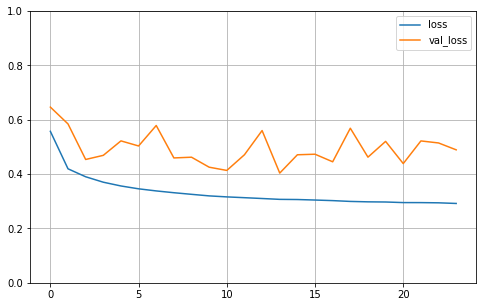

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Once you are satisfied with your model’s validation loss, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production.

But first, you should import the test set and do the similar thing you done on training set, before use `compile()` to evaluate your model.

In [12]:
import pandas as pd

df_test = pd.read_excel('/content/sample_data/housing_price_test.xlsx')

df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-117.20,33.14,19.0,2025.0,414.0,1663.0,403.0,38147.0,<1H OCEAN,139200.0
1,-117.22,33.14,5.0,4576.0,848.0,2314.0,705.0,50123.0,NEAR OCEAN,210400.0
2,-117.21,33.14,12.0,4839.0,954.0,1708.0,952.0,28586.0,<1H OCEAN,163300.0
3,-117.21,33.13,15.0,1889.0,368.0,754.0,409.0,22278.0,NEAR OCEAN,132800.0
4,-117.17,33.18,25.0,596.0,115.0,426.0,137.0,30221.0,<1H OCEAN,214300.0


In [13]:
print(df_test.shape)

(5110, 10)


Based on test data, we only have 5.110 data. Then used `labelEncoder` class to convert the ocean_proximity to a number.

In [14]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string data into numbers.
ocean_proximity_encoded = le.fit_transform(df_test['ocean_proximity'])
print("ocean_proximity:",ocean_proximity_encoded[0:5])
df_test['ocean_proximity'] = ocean_proximity_encoded
df_test.head()

ocean_proximity: [0 3 0 3 0]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-117.20,33.14,19.0,2025.0,414.0,1663.0,403.0,38147.0,0,139200.0
1,-117.22,33.14,5.0,4576.0,848.0,2314.0,705.0,50123.0,3,210400.0
2,-117.21,33.14,12.0,4839.0,954.0,1708.0,952.0,28586.0,0,163300.0
3,-117.21,33.13,15.0,1889.0,368.0,754.0,409.0,22278.0,3,132800.0
4,-117.17,33.18,25.0,596.0,115.0,426.0,137.0,30221.0,0,214300.0


In [15]:
data_test = df_test[feature_names].values
labels_test = df_test[label_name].values

print(data_test.shape)
print(labels_test.shape)

(5110, 9)
(5110, 1)


Scale the test set to improve the evaluation process

In [16]:
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler

PredictorScalerFit = StandardScaler().fit(data_test)
LabelsScalerFit = StandardScaler().fit(labels_test)

# Generating the standardized values of X and y
X_test = PredictorScalerFit.transform(data_test)
y_test = LabelsScalerFit.transform(labels_test)

Make a prediction using the model you build in the training set, the evaluate it using `evaluate()`

In [17]:
# Generating Predictions on testing data
Predictions=model_nn.predict(X_test)
mse_ann_test = model_nn.evaluate(X_test, y_test)
print('ANN MSE:', mse_ann_test)

160/160 [==============================] - 0s 1ms/step - loss: 0.6826
ANN MSE: 0.6826391220092773


Based on the evaluation process, the model give loss value about 0.642 on the test set. You can either change the model hyperparameters to make the result better, or just keep going to produce the results.

If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. The first one to try is change another `optimizer`. If the performance is still not great, then try tuning model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer. You can also try tuning other hyperparameters, such as the batch size (it can be set in the fit() method using the `batch_size argument`, which defaults to 32).

If you satisfied with the model, you should rescale the labels and the predicted value into its original form. So, you can see better visualization.

In [18]:
# Scaling the predicted and actual value Price data back to original price scale
ann_predictions = LabelsScalerFit.inverse_transform(Predictions)
y_test_orig = LabelsScalerFit.inverse_transform(y_test)

TestingData = pd.DataFrame(data=data_test, columns=feature_names)

Compare the predicted with the actual value with the table

In [19]:
TestingData['median_house_income'] = y_test_orig
TestingData['ann_predictions'] = ann_predictions
TestingData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_income,ann_predictions
0,-117.20,33.14,19.0,2025.0,414.0,1663.0,403.0,38147.0,0.0,139200.0,163501.453125
1,-117.22,33.14,5.0,4576.0,848.0,2314.0,705.0,50123.0,3.0,210400.0,209425.203125
2,-117.21,33.14,12.0,4839.0,954.0,1708.0,952.0,28586.0,0.0,163300.0,411590.312500
3,-117.21,33.13,15.0,1889.0,368.0,754.0,409.0,22278.0,3.0,132800.0,252482.390625
4,-117.17,33.18,25.0,596.0,115.0,426.0,137.0,30221.0,0.0,214300.0,159138.531250


We can also visualize the absolute percentage error (APE) from both predicted and actual value usng code below, then visualize it

In [20]:
import numpy as np

ann_APE = 100*(abs(TestingData['median_house_income']-TestingData['ann_predictions'])/TestingData['median_house_income'])
TestingData['ann_APE'] = ann_APE

print('The Accuracy of ANN model is: {0:.3f}'.format(100-np.mean(ann_APE)))
TestingData.head()

The Accuracy of ANN model is: 60.439


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_income,ann_predictions,ann_APE
0,-117.20,33.14,19.0,2025.0,414.0,1663.0,403.0,38147.0,0.0,139200.0,163501.453125,17.457940
1,-117.22,33.14,5.0,4576.0,848.0,2314.0,705.0,50123.0,3.0,210400.0,209425.203125,0.463306
2,-117.21,33.14,12.0,4839.0,954.0,1708.0,952.0,28586.0,0.0,163300.0,411590.312500,152.045507
3,-117.21,33.13,15.0,1889.0,368.0,754.0,409.0,22278.0,3.0,132800.0,252482.390625,90.122282
4,-117.17,33.18,25.0,596.0,115.0,426.0,137.0,30221.0,0.0,214300.0,159138.531250,25.740303


Visualized the result using matplotlib

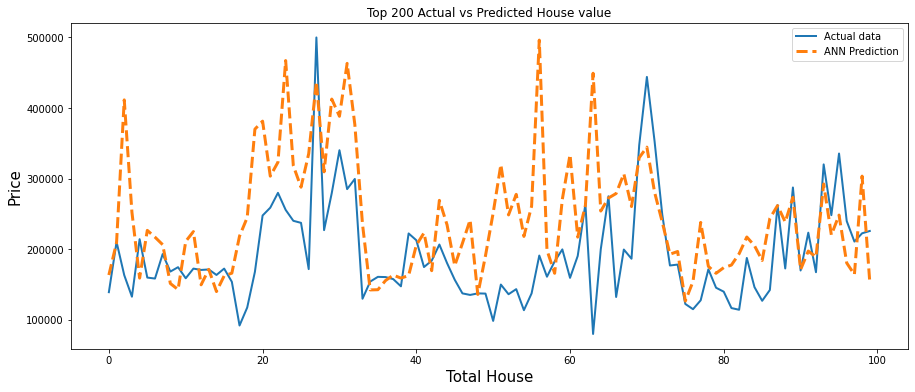

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(TestingData['median_house_income'][0:100], lw =2, ls = '-', label = 'Actual data')
plt.plot(TestingData['ann_predictions'][0:100], lw =3, ls = '--', label = 'ANN Prediction')
plt.xlabel('Total House', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.title('Top 200 Actual vs Predicted House value')
plt.legend()